In [1]:
import pandas as pd
import streamlit as st
import duckdb
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pmdarima import auto_arima
from meteostat import Point, Hourly
import holidays

def load_data():
    con = duckdb.connect(database=':memory:', read_only=False)
    path=r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data\combined_sampled_data.parquet"
    df = con.execute(f"SELECT * FROM '{path}'").df()
    return df
data = load_data()


In [2]:
data=data[data['total_amount']>0]
data=data[data['trip_distance']<=100]
data['Date']=data['tpep_pickup_datetime'].dt.date
data['Hour']=data['tpep_pickup_datetime'].dt.hour
data['Date']=pd.to_datetime(data['Date'])
data=data[(data['Date'].dt.year)==2025]

In [3]:
data['passenger_count'].fillna(0, inplace=True)
data['RatecodeID'].fillna(-1, inplace=True)
data['store_and_fwd_flag'].fillna('N', inplace=True)
data['congestion_surcharge'].fillna(0, inplace=True)
data['Airport_fee'].fillna(0, inplace=True)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [4]:
location = Point(40.7128, -74.0060)  # NYC example
weather = Hourly(
    location,
    start=data['Date'].min(),
    end=data['Date'].max()
).fetch().reset_index()

weather = weather[['time', 'temp', 'prcp', 'wspd']]
weather.rename(columns={'time': 'Date'}, inplace=True)

df = data.merge(weather, on='Date', how='left')

In [5]:
us_holidays = holidays.US(years=df['Date'].dt.year.unique())
df['is_holiday'] = df['Date'].isin(us_holidays).astype(int)

In [6]:
df['is_festive_window'] = 0

for holiday_date in us_holidays:
    festive_range = pd.date_range(
        start=pd.to_datetime(holiday_date) - pd.Timedelta(days=2),
        end=pd.to_datetime(holiday_date) + pd.Timedelta(days=2)
    )
    df.loc[df['Date'].isin(festive_range), 'is_festive_window'] = 1

In [7]:
import requests

def get_nyc_weather(start, end):
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude=40.7128&longitude=-74.0060"
        f"&start_date={start}&end_date={end}"
        "&daily=temperature_2m_mean,precipitation_sum"
        "&timezone=America/New_York"
    )
    return requests.get(url).json()

weather_json = get_nyc_weather(
    df['Date'].min().strftime('%Y-%m-%d'),
    df['Date'].max().strftime('%Y-%m-%d')
)

In [8]:
weather_df = pd.DataFrame({
    'Date': pd.to_datetime(weather_json['daily']['time']),
    'avg_temp': weather_json['daily']['temperature_2m_mean'],
    'precipitation': weather_json['daily']['precipitation_sum']
})

In [9]:
df = df.merge(weather_df, on='Date', how='left')

In [10]:
df['is_rainy'] = (df['precipitation'] > 5).astype(int)
df['is_cold'] = (df['avg_temp'] < 5).astype(int)
df['is_hot'] = (df['avg_temp'] > 30).astype(int)

In [11]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,temp,prcp,wspd,is_holiday,is_festive_window,avg_temp,precipitation,is_rainy,is_cold,is_hot
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,-1.1,0.0,7.6,0,0,-4.5,0.0,0,1,0
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.0,0.0,0.0,0,0,0.5,0.0,0,1,0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,-7.8,0.0,18.4,0,1,-12.0,0.0,0,1,0
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,-5.6,0.0,20.5,0,1,-11.4,0.4,0,1,0
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,-1.7,0.0,13.0,0,0,-0.7,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,14.0,0.0,7.0,0,0,10.0,0.1,0,0,0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,15.0,0.0,17.0,0,0,13.5,0.1,0,0,0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0


In [12]:
df.to_parquet(r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data/data_with_exrogenous.parquet")

In [13]:
df.set_index('tpep_pickup_datetime',inplace=True)

In [14]:
sarimax_df = df.resample('H').agg({
    'VendorID': 'count',        # trips per hour
    'temp': 'mean',
    'prcp': 'mean',
    'wspd': 'mean',
    'is_holiday': 'max',
    'is_festive_window': 'max',
    'is_rainy': 'max',
    'is_cold': 'max',
    'is_hot': 'max'
})

In [15]:
sarimax_df

,VendorID,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot
tpep_pickup_datetime,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0


In [16]:
sarimax_df = sarimax_df.rename(columns={'VendorID': 'Trips'})

In [17]:
y = sarimax_df['Trips']
y = pd.DataFrame(y)
exog_cols = [
    'temp', 'prcp', 'wspd',
    'is_holiday', 'is_festive_window',
    'is_rainy', 'is_cold', 'is_hot'
]

X = sarimax_df[exog_cols]

In [18]:
X.fillna(0,inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
X_encoded = X.copy()
object_cols = X_encoded.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Ensure all columns are float
X_encoded = X_encoded.astype(float)

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [22]:
sarimax_model = SARIMAX(
    y['Trips'],
    exog=X_encoded,
    order=(2, 0, 0),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [23]:
sarimax_results = sarimax_model.fit(disp=False)

In [24]:
import pickle

In [25]:
file_path =r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\models\sarimax_exogenous__model.pkl"

In [26]:
with open(file_path, 'wb') as file:
    pickle.dump(sarimax_results,file)


In [27]:
with open(file_path, 'rb') as file:
    sarimax_exogenous_model = pickle.load(file)
    print("Model Loaded")

Model Loaded


In [28]:
sarimax_exogenous_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Trips   No. Observations:                 7296
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood              -41770.294
Date:                              Mon, 22 Dec 2025   AIC                          83566.588
Time:                                      16:27:46   BIC                          83656.178
Sample:                                  01-01-2025   HQIC                         83597.401
                                       - 10-31-2025                                         
Covariance Type:                                opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
temp                 14.0226      0.548     25.580      0.000      12.948      15.097
prcp                 67.9079      3.923     17.312      0.000      60.220      75.596
wspd                 -5.2111      0.245    -21.245      0.000      -5.692      -4.730
is_holiday         -112.4206     10.342    -10.870      0.000    -132.690     -92.151
is_festive_window   -26.9175     12.214     -2.204      0.028     -50.857      -2.978
is_rainy             77.3560      4.584     16.875      0.000      68.372      86.340
is_cold             363.3813      4.655     78.064      0.000     354.258     372.505
is_hot             -181.8022     19.545     -9.302      0.000    -220.110    -143.495
ar.L1                 1.1952      0.008    146.856      0.000       1.179       1.211
ar.L2                -0.3422      0.009    -38.544      0.000      -0.360      -0.325
ar.S.L24              0.9993      0.000   2118.113      0.000       0.998       1.000
ma.S.L24             -0.9643      0.003   -279.218      0.000      -0.971      -0.958
sigma2             6048.4251     72.156     83.825      0.000    5907.003    6189.847
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              4895.98
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
sarimax_df

,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax
tpep_pickup_datetime,,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,-159.045861
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,860.494735
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,711.974726
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,482.068727
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,250.494437
...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1042.033278
2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1103.275678
2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1025.275843


In [30]:
sarimax_df['Fitted Values Sarimax']=sarimax_results.fittedvalues

In [31]:
sarimax_df.to_csv(r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data/sarimax_exogenous_Data_with_resample.csv")

In [32]:
sarimax_df.index.month==1

array([ True,  True,  True, ..., False, False, False])

In [33]:
def load_exogenous_data():
    path=r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data/sarimax_exogenous_Data_with_resample.csv"
    df = pd.read_csv(path)
    return df
data_exogenous = load_exogenous_data()


In [34]:
data_exogenous.reset_index(drop=True,inplace=True)

In [35]:
data_exogenous['tpep_pickup_datetime'] =pd.to_datetime(data_exogenous['tpep_pickup_datetime'])

In [36]:
data_exogenous.dtypes

tpep_pickup_datetime     datetime64[ns]
Trips                             int64
temp                            float64
prcp                            float64
wspd                            float64
is_holiday                      float64
is_festive_window               float64
is_rainy                        float64
is_cold                         float64
is_hot                          float64
Fitted Values Sarimax           float64
dtype: object

In [40]:
month_1=data_exogenous[data_exogenous['tpep_pickup_datetime'].dt.month==1]

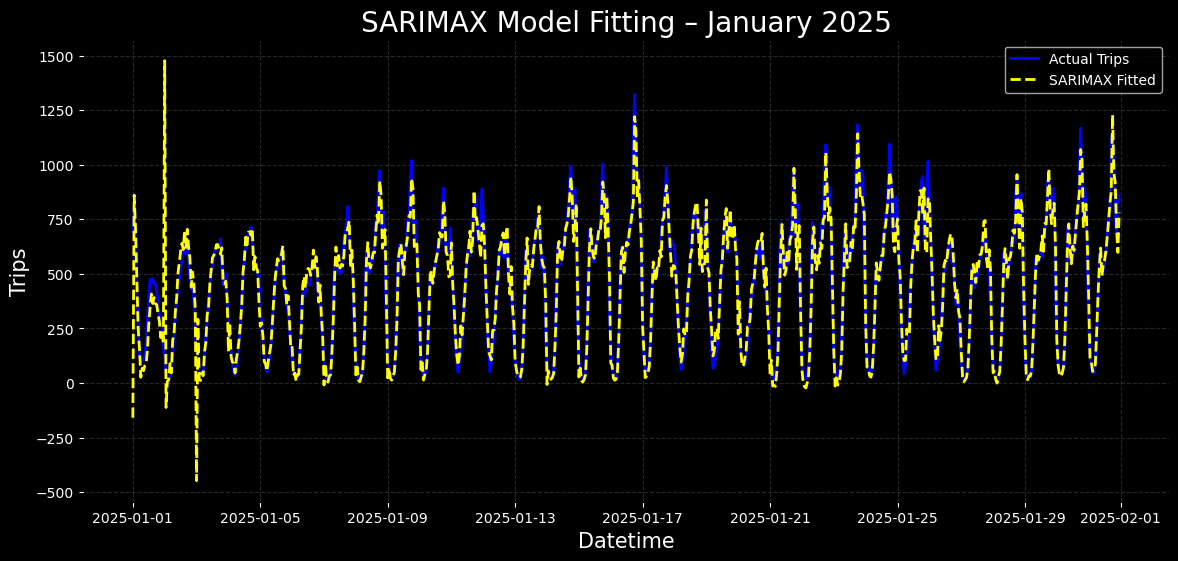

In [42]:
%matplotlib inline
fig2, ax2 = plt.subplots(figsize=(14,6))

# Background colors
fig2.patch.set_facecolor('black')
ax2.set_facecolor('black')

# Plot lines (high contrast)
ax2.plot(
    month_1['tpep_pickup_datetime'],
    month_1['Trips'],
    label='Actual Trips',
    color='blue',
    linewidth=2
)


ax2.plot(
    month_1['tpep_pickup_datetime'],
    month_1['Fitted Values Sarimax'],
    label='SARIMAX Fitted',
    color='yellow',
    linestyle='--',
    linewidth=2
)
# Labels & title
ax2.set_xlabel('Datetime', color='white',fontsize=15)
ax2.set_ylabel('Trips', color='white',fontsize=15)
ax2.set_title('SARIMAX Model Fitting – January 2025', color='white', fontsize=20)

# Ticks
ax2.tick_params(colors='white')

# Grid (optional but recommended)
ax2.grid(color='gray', linestyle='--', alpha=0.3)

# Legend
ax2.legend(facecolor='black', labelcolor='white')
plt.show()